In [15]:
import math 
import matplotlib.pyplot as plt
from sympy import symbols, diff
import re
import numpy as np

import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [16]:
# Data : 
# Продаж солодкої води :

x = [i for i in range(1,37)]

y = [9,10,10,11,12,18,26,40,39,28,20,13,
     8,9,11,9,13,15,33,45,45,25,18,10,
     7,9,10,11,13,15,31,40,35,26,19,13]




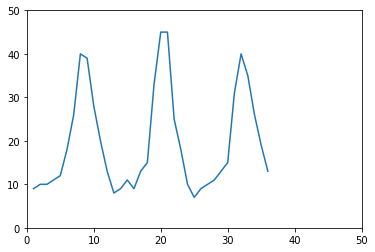

In [17]:
plt.plot(x, y)
plt.axis([0, 50, 0, 50])
plt.show()

In [18]:
## Stage find regressions : 

def Cov(a,b):
    a = list(a)
    b = list(b)
    
    avr_a = 0
    for i in range(len(a)):
        avr_a +=a[i]
    avr_a /=len(a)
    
    avr_b = 0
    for i in range(len(b)):
        avr_b += b[i]
    avr_b /= len(b)
    
    znamenik = 0
    for i in range(len(a)):
        znamenik += (a[i] - avr_a) * (b[i] - avr_b)
    
    chiselnik = len(a) - 1
    
    cov = 0 
    
    cov = znamenik / chiselnik
    
    return cov


In [19]:
print('кореляція = ', Cov(x,y))

кореляція =  18.62857142857143


In [20]:
def standart_error(a,b):
    # Дисперсії :
    avr_a = 0
    for i in range(len(a)):
        avr_a += a[i]
    avr_a /=len(a)
    
    avr_b = 0
    for i in range(len(b)):
        avr_b += b[i]  
    avr_b /= len(b)
    
    d_a = 0 # dispersia
    for i in range(len(a)):
        d_a += math.pow((a[i] - avr_a),2)
        
    d_b = 0 # dispersia
    for i in range(len(b)):
        d_b += math.pow((b[i] - avr_b),2)
        
    # Стандартне відхилення :
    std_a = 0
    std_b = 0
    
    std_a = math.pow(d_a,(0.5))
    std_b = math.pow(d_b ,(0.5))
    
    return std_a,std_b 

def rxy(a,b):
    std_a,std_b = standart_error(a,b)
    # cof_korell :
    cov = Cov(a,b)
    cof_korell = cov / (std_a * std_b)
    
    return cof_korell
print('Кофіцієнт кореляції :',rxy(x,y))

Кофіцієнт кореляції : 0.00429572464444998


In [21]:
print('Кофіцієнт детермінації : ',math.pow(rxy(x,y),(0.5)))

Кофіцієнт детермінації :  0.06554177785542577


In [22]:
def firstRegressor(a,b):
    std_a,std_b = standart_error(a,b)
    cov = Cov(a,b)
    
    # Регресор :
    first = (std_a / std_b) * cov
    return first 
firstRegressor(x,y)

16.688890243688178

In [23]:
def secondRegressor(a,b):
    avr_a = 0
    for i in range(len(a)):
        avr_a += a[i]
    avr_a /= len(a)
    
    avr_b = 0
    for i in range(len(b)):
        avr_b += b[i]
    avr_b /= len(b)
    first = firstRegressor(a,b)
    
    second = avr_b - (first * avr_a)
    return second
secondRegressor(x,y)

-289.1333583971202

In [24]:
def minMNK(a,b):
    function = 0
    w0, w1 = symbols('x y', real=True)
    
    for i in range(len(a)):
        function +=(w1*a[i] + w0 - b[i]) ** 2
        
    #print(function)
    
    function1W0 = diff(function,w0)
    function2W1 = diff(function,w1)
        
    #print(function1W0)
   # print(function2W1)
    
    function1W0 = str(function1W0)
    function2W1 = str(function2W1)
    

    result1 = re.findall(r'\d+',function1W0)
    result2 = re.findall(r'\d+',function2W1)
    
    for i in range(len(result1)):
        result1[i] = int(result1[i])
        
    for i in range(len(result2)):
        result2[i] = int(result2[i])
    
    
    matrix = [result1[0:2],result2[0:2]]
    matrix_result = [result1[2],result2[2]]
    
    #print('\n')
    
    #for i in range(2):
       # print(matrix[i],'  \t=   ',matrix_result[i])
    
    #print(matrix)
    #print(matrix_result)
    resultAll = np.linalg.solve(matrix,matrix_result)
    
    new_w0, new_w1 = resultAll
    
    return new_w0, new_w1
minMNK(x,y)  

(16.506349206349206, 0.16782496782496775)

In [25]:
def linerRegression(a,b,x):
    w0,w1 = minMNK(a,b)
    y = w0 + (w1*x)
    return y 

In [26]:
print('Результат лінійної регресі на 37 місяць : ', linerRegression(x,y,37))

Результат лінійної регресі на 37 місяць :  22.715873015873015


## DegreeData : 

In [27]:
data = pd.read_csv('full_external_temperatures.csv',header=0, parse_dates=[0], index_col=0, squeeze=True)

In [28]:
x = []
temp_x = []
temp_x.extend(data['dateTime'])
for i in range(2000):
    x.append(temp_x[i])
    
x_data = []
for i in range(200):
    x_data.append(i)

In [29]:
y = []
temp_y = []
temp_y.extend(data['data'])
for i in range(200):
    y.append(temp_y[i])

In [30]:
test_y = []
temp_y = []
temp_y.extend(data['data'])
for i in range(2003):
    test_y.append(temp_y[i])

In [31]:
train = pd.DataFrame({'time':x_data,'value':y})

In [32]:
# Автокорегресія :
def auto_reg(a,b,p=1):
    w0,w1 = minMNK(a,b)
    function = w0
    #print(w0)
    result_array = []
    for i in range(p):
        len_arr = len(a) - i -1
        
        w0,w1 = minMNK(a[0:len_arr],b[0:len_arr])
        #print('liner - ',res_liner_regr, 'b - ',b[len_arr])
        function += b[len_arr] * w1
        
        result_array.append(function)
    return function
auto_reg(x_data,y,p=5)

8.931993883482486

In [33]:
# Скільзьке середнє :
def SMA(b,p=3):
    SMA_res = []
    sum_b = 0
    num = 0
    for i in range(len(b) - p):
        for j in range(p):
            sum_b += b[i+j]
        SMA_res.append(sum_b / p)
        sum_b = 0
    return SMA_res
def MA_foresee(b,p):
    SMA_res = 0

    for i in range(p):
        sum_b = len(b) - i -1
        SMA_res += b[sum_b]
        SMA_res /= p
    return SMA_res
def MAGrath(b,p=3):
    SMA_res = []
    sum_b = 0
    num = 0
    for i in range(len(b) - p):
        for j in range(p):
            sum_b += b[i+j]
        SMA_res.append(sum_b / p)
        sum_b = 0
    return SMA_res

MA_foresee(y,2)

8.254999999999999

In [34]:
MA_arr = [0,0,0]
temp_arr = SMA(y)
for i in range(len(temp_arr)):
    MA_arr.append(temp_arr[i])

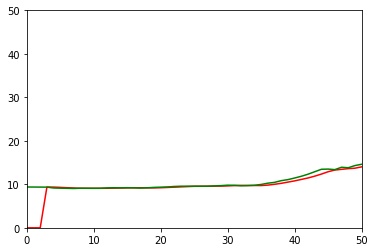

In [35]:
plt.plot(x_data,MA_arr,'r')
plt.plot(x_data, y,'g')
plt.axis([0, 50, 0, 50])
plt.show()

In [36]:
test_y = []
temp_y = []
temp_y.extend(data['data'])
for i in range(2003):
    test_y.append(temp_y[i])

In [37]:
print(test_y[201])

10.29


result MA =  <class 'numpy.float64'>
result AR =  <class 'numpy.float64'>


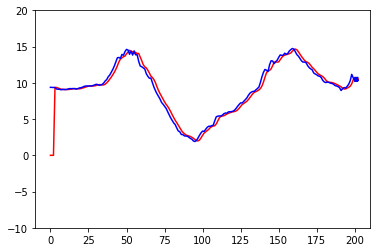

predict 10.377690447771062
True value 10.29


In [56]:
def ARIMA(x,y,my_x,p,q,d):
    new_y = [0]
    new_y1 = []
    
    MA_plust_ar = 0
    
    if d == 0:
        MA_res = MA_foresee(y,q)
        AR_res = auto_reg(x_data,y,p=p)
        print("result MA = ", type(MA_res))
        print("result AR = ", type(AR_res))
        MA_plust_ar = MA_res + AR_res
        
        arr_MA = [0,0,0]
        temp_MA = MAGrath(y)
        for i in range(len(temp_MA)):
            tr = temp_MA[i]
            arr_MA.append(tr)
        plt.plot(x_data,arr_MA,'r')
        plt.plot(x_data,y,'b')
        plt.axis([-10, 210, -10, 20])
        plt.show()
    elif d == 1:
        for i in range(len(y)):
            num = y[i] - y[i-1]
            new_y.append(int(num))
            num = 0
        MA_res = MA_foresee(new_y,q)
        AR_res = auto_reg(x_data,new_y,p=p)
        print("result MA = ", MA_res)
        print("result AR = ", AR_res)
        MA_plust_ar = MA_res + AR_res
      
    elif d == 2:
        for i in range(len(y)):
            num = y[i] - y[i-1]
            new_y.append(int(num))
            num = 0
        for i in range(len(new_y)):
            num = new_y[i] - new_y[i-1]
            new_y1.append(num)
            num = 0
        arr_MA = SMA(new_y1,p)
        res_MA = 0
        for i in range(len(arr_MA)):
            res_MA += arrMA[i]
        arr_AR = auto_reg()
        
    return "predict " + str(MA_plust_ar)
        
print(ARIMA(x_data,y,my_x=1,p=1,q=7,d=0))
print("True value",test_y[201])

result MA =  <class 'numpy.float64'>
result AR =  <class 'numpy.float64'>


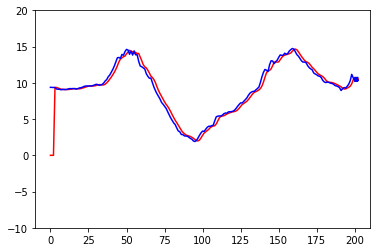

predict 10.860161755681633


In [57]:
print(ARIMA(x_data,y,my_x=201,p=2,q=6,d=0))

In [40]:
def ARIMA_with_Prediction(step, x,y,p,q,d):
  new_y = [0]
  new_y1 = []
  
  resut_arr = []
  MA_plust_ar = 0
  
  if d == 0:
    new_x = []
    new_y = []
    new_x = x
    new_y = y
    my_x_x = 199
    for i in range(step):
      MA_res = MA_foresee(new_y,q)
      AR_res = auto_reg(new_x,new_y,p=p)
      MA_plust_ar = MA_res + AR_res
      resut_arr.append(MA_plust_ar)
      new_y.append(MA_plust_ar)
      my_x_x +=1
      new_x.append(my_x_x)

  return resut_arr
print("Predicted = ",ARIMA_with_Prediction(3,x_data,y,p=1,q=7,d=0))
print("True value = ", test_y[201],",   ",test_y[202],",   ",test_y[203])

Predicted =  [10.243201426497652, 10.239743137128386, 10.273958496080168]
True value =  10.29 ,    10.13 ,    10.11


In [45]:

from pyramid.arima import auto_arima
model = auto_arima(y, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y)
forecast = model.predict(3)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=14.654, BIC=34.503, Fit time=0.811 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=91.853, BIC=98.470, Fit time=0.067 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=34.098, BIC=44.023, Fit time=0.107 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=57.924, BIC=67.849, Fit time=0.127 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=12.702, BIC=29.243, Fit time=0.569 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=11.723, BIC=24.956, Fit time=0.285 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=12.655, BIC=29.196, Fit time=0.392 seconds
Total fit time: 2.369 seconds
[10.27357231 10.27332909 10.27322035]


In [52]:
print("AutoArima : ",forecast)
print("Predicted = ",ARIMA_with_Prediction(3,x_data,y,p=1,q=7,d=0))
print("True value = ", test_y[201],",   ",test_y[202],",   ",test_y[203])

AutoArima :  [10.27357231 10.27332909 10.27322035]
Predicted =  [10.39171210757265, 10.392524629546758, 10.381670780971682]
True value =  10.29 ,    10.13 ,    10.11
